In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_cosmology import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform2d import DWT2d
from utils import get_2dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_2dfilts, plot_2dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec

# load results

In [4]:
dirs = ["db5_saliency_warmstart_seed=1"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/adaptive-wavelets/notebooks/cosmology/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT2d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [5]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)

index2o = {}
index2t = {}
num = 0
for i, _ in enumerate(lamL1wave_grid):
    for j, _ in enumerate(lamL1attr_grid):
        loc = (lamL1wave == lamL1wave_grid[i]) & (lamL1attr == lamL1attr_grid[j])
        if loc.sum() == 1: 
            loc = np.argwhere(loc).flatten()[0]
            index2o[(i,j)] = loc
            index2t[num] = (i,j)
        num += 1
            
R = len(lamL1wave_grid)
C = len(lamL1attr_grid)
psi_list = []
wt_list = []
for r in range(R):
    for c in range(C):
        wt = mos[index2o[(r,c)]]
        wt_list.append(wt)
        phi, psi, x = get_wavefun(wt)
        psi_list.append(psi)            

# Plotting

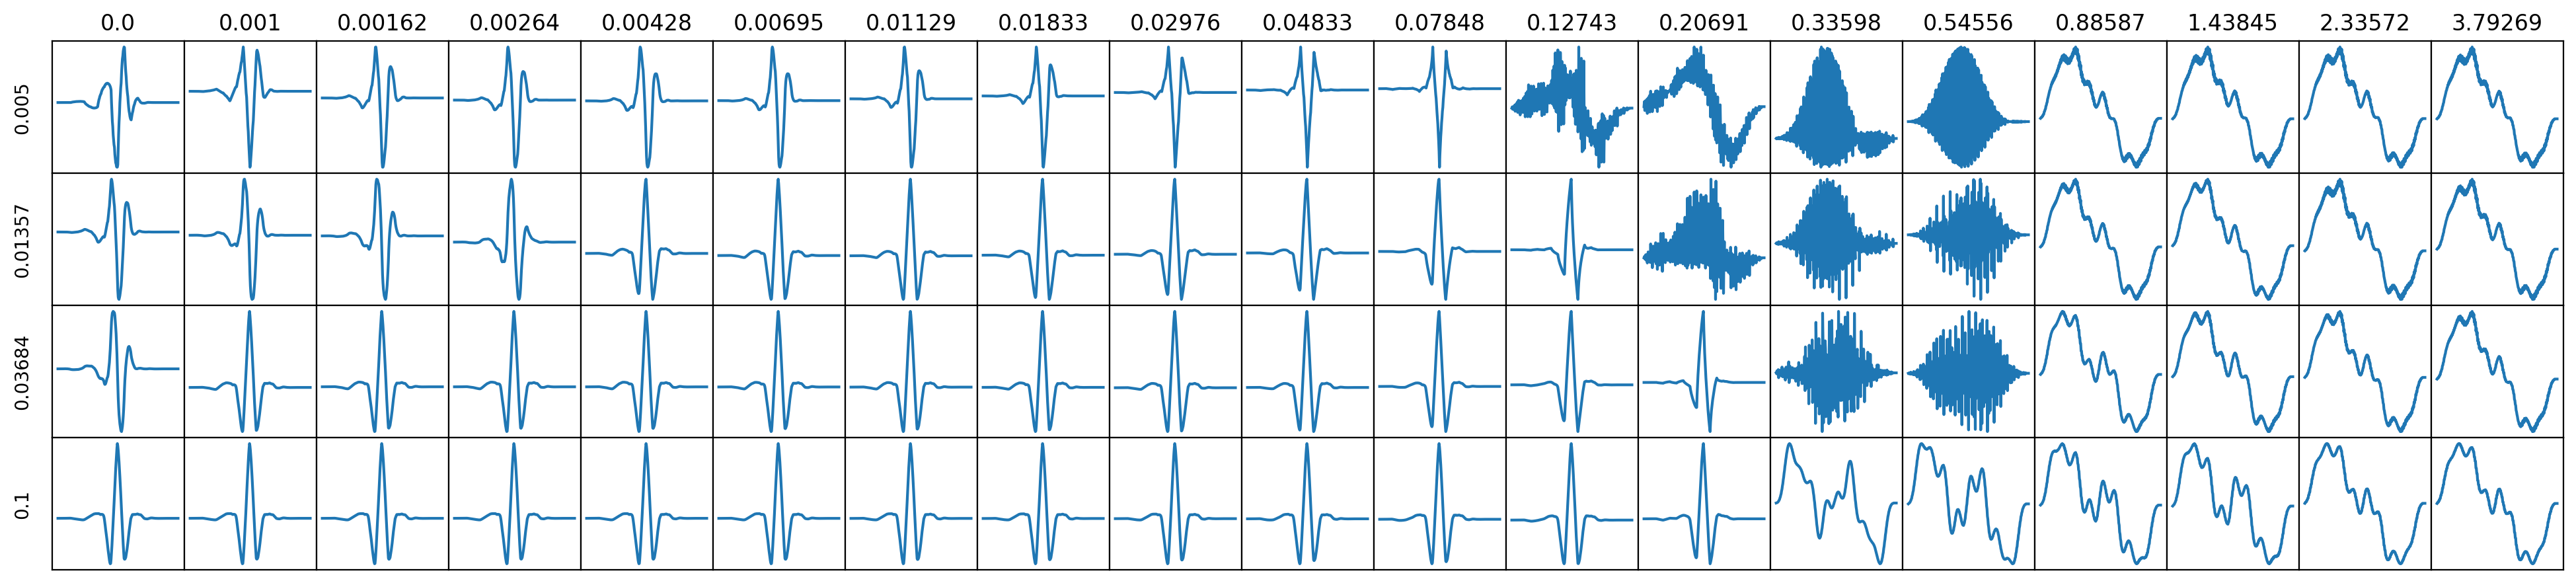

In [6]:
plt.figure(figsize=(C+1, R+1), dpi=200)
gs = gridspec.GridSpec(R, C,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(R+1), bottom=0.5/(R+1), 
         left=0.5/(C+1), right=1-0.5/(C+1))     

i = 0
for r in range(R):
    for c in range(C):
        ax = plt.subplot(gs[r,c])
        ax.plot(x, psi_list[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,
            left=False,
            right=False,
            labelbottom=False) 
        if c == 0:
            plt.ylabel(str(lamL1wave_grid[r]))
        if r == 0:
            plt.title(str(lamL1attr_grid[c]))
        i += 1
plt.show()

Hyperparameter: lamL1wave=0.100000 lamL1attr=0.335980
Error: Recon=19.221607
Sparsity: Wave=0.414047
Interp: Saliency=1.475622 InputXGrade=0.000059
Wavelet loss: lSum=0.521288 hsum=0.000000 L2norm=0.483903 CMF=9.687378 Conv=0.484214


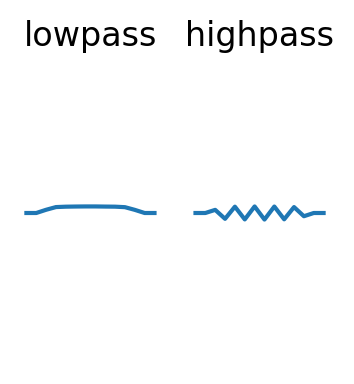

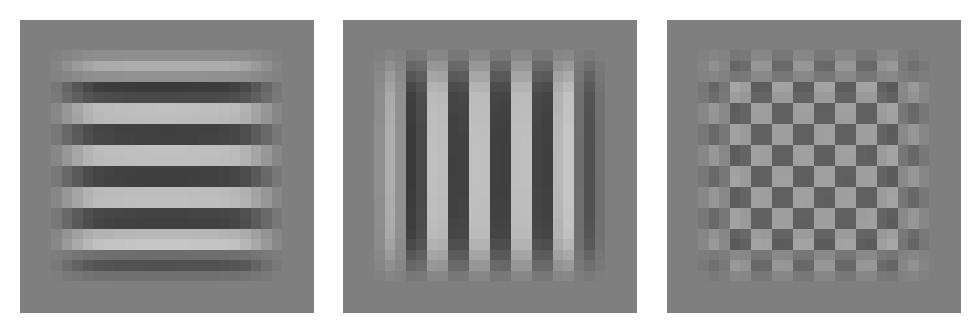

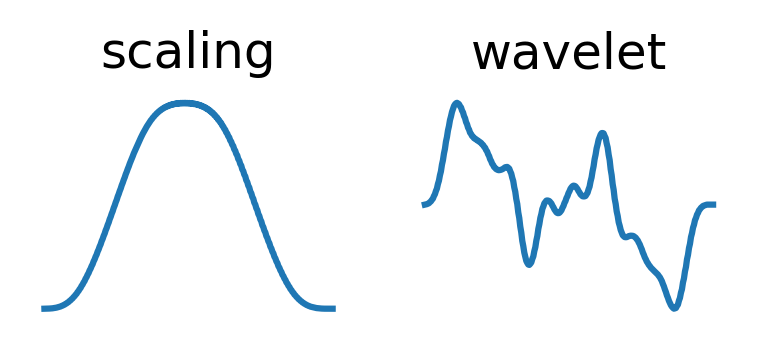

In [11]:
idx1 = 3
idx2 = 13
wt = mos[index2o[(idx1, idx2)]]
filt = get_2dfilts(wt)
phi, psi, x = get_wavefun(wt)

# print 
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][index2o[(idx1, idx2)]], res['lamL1attr'][index2o[(idx1, idx2)]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][index2o[(idx1, idx2)]]))
print('Sparsity: Wave={:.6f}'.format(res['L1wave_loss'][index2o[(idx1, idx2)]]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(res['L1saliency_loss'][index2o[(idx1, idx2)]], res['L1inputxgrad_loss'][index2o[(idx1, idx2)]]))
print('Wavelet loss: lSum={:.6f} hsum={:.6f} L2norm={:.6f} CMF={:.6f} Conv={:.6f}'.format(res['lsum_loss'][index2o[(idx1, idx2)]],
                                                                                          res['hsum_loss'][index2o[(idx1, idx2)]],
                                                                                          res['L2norm_loss'][index2o[(idx1, idx2)]],
                                                                                          res['CMF_loss'][index2o[(idx1, idx2)]],
                                                                                          res['conv_loss'][index2o[(idx1, idx2)]]))


plot_1dfilts(filt[0], is_title=True, figsize=(2,2))
plot_2dfilts(filt[1], figsize=(5,5))
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))

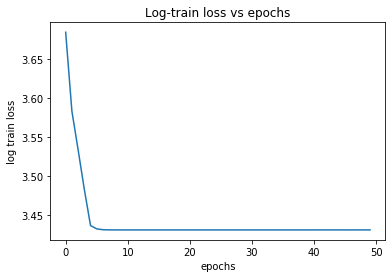

In [8]:
plt.plot(np.log(res['train_losses'][index2o[(idx1, idx2)]]))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

Reconstruction error=19.00914


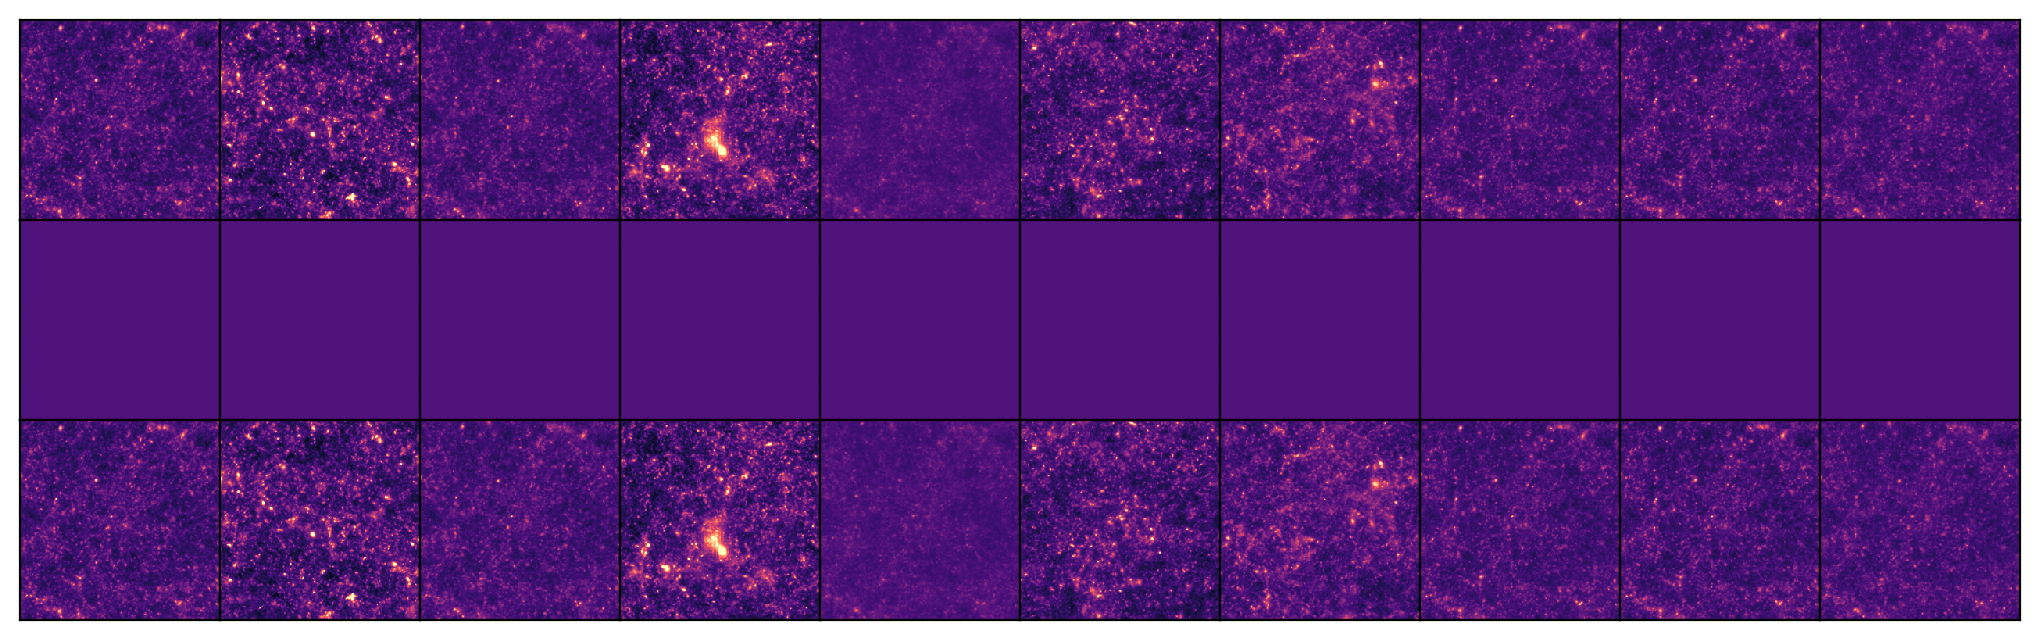

In [10]:
#### plot original and reconstruction images
train_loader, test_loader = get_dataloader(p.data_path, 
                                           img_size=p.img_size[2],
                                           split_train_test=True,
                                           batch_size=p.batch_size)  
data = iter(test_loader).next()[0].to(device)

data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))
plot_2dreconstruct(data, recon)